In [1]:
from datetime import date
print(date.today())

2023-05-10


# 3. Integration

Objectives: 

1. List possible sources of differences between single-cell datasets
1. Explain why these differences may lead to problems, i.e. in cell type detection or diff. gene expression
1. List the main strategies for dataset integration
    - global models
    - linear embedding models
    - graph-based methods
    - deep learning
1. Find and parse recent benchmarking publications
1. Explain their preference for a benchmarking strategy/method
1. Run integration method on dataset
1. Demonstrate that integration achieved the intended effect

### 3.1 Why is integration needed?

- have students run without integration and see what happens
- construct possible scenarios/experimental designs that could lead to batch effects
- take away lessons for experimental design. Are there ways to prevent batch effects?

### 3.2 How do we integrate?

- work on gold standard (HCA or MCA)
- run different tools (at least in Python ecosystem):
    - UMI downsampling
    - BBKNN
    - MNN
    - pyHarmony
    - pyLiger
    - scVI
    - scANVI

What do we learn from the integrated data that we couldn't learn before?

### 3.3 How do we evaluate if it worked?

- discuss with students: What would we expect? How would we measure it?
- use [`scib`](https://github.com/theislab/scib) from [Luecken _et al._
  2021](https://www.nature.com/articles/s41592-021-01336-8), [PMD](https://bitbucket.org/scottyler892/pyminer_norm/src)
  from [Tyler _et al._ 2021](https://www.biorxiv.org/content/10.1101/2021.11.15.468733v1.full)
- see how homogeneous each cluster is before/after
- HVG conservation before/after
- run Alison's method (z-scores) and UMI downsampling as baseline integration
- compare to "no integration at all"
- positive/negative controls?

In [41]:
import glob
import scanpy as sc
import anndata as ad

import matplotlib.pyplot as plt

In [4]:
patients = {}
out = "/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/human_pancreas/patients"
for patient in glob.glob(out + "/*"):
    patient_id = patient.split("_")[-1].split(".")[0]
    patients[patient_id] = sc.read_h5ad(patient)

# No integration

In [31]:
naive = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
naive.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(naive, inplace=True)

In [33]:
sc.pp.normalize_per_cell(naive, counts_per_cell_after=None)
sc.pp.log1p(naive)
sc.pp.highly_variable_genes(naive, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(naive, n_comps=50, use_highly_variable=True, chunked=True)
sc.pp.neighbors(naive, n_neighbors=10, n_pcs=40, metric="cosine")
sc.tl.umap(naive, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No d

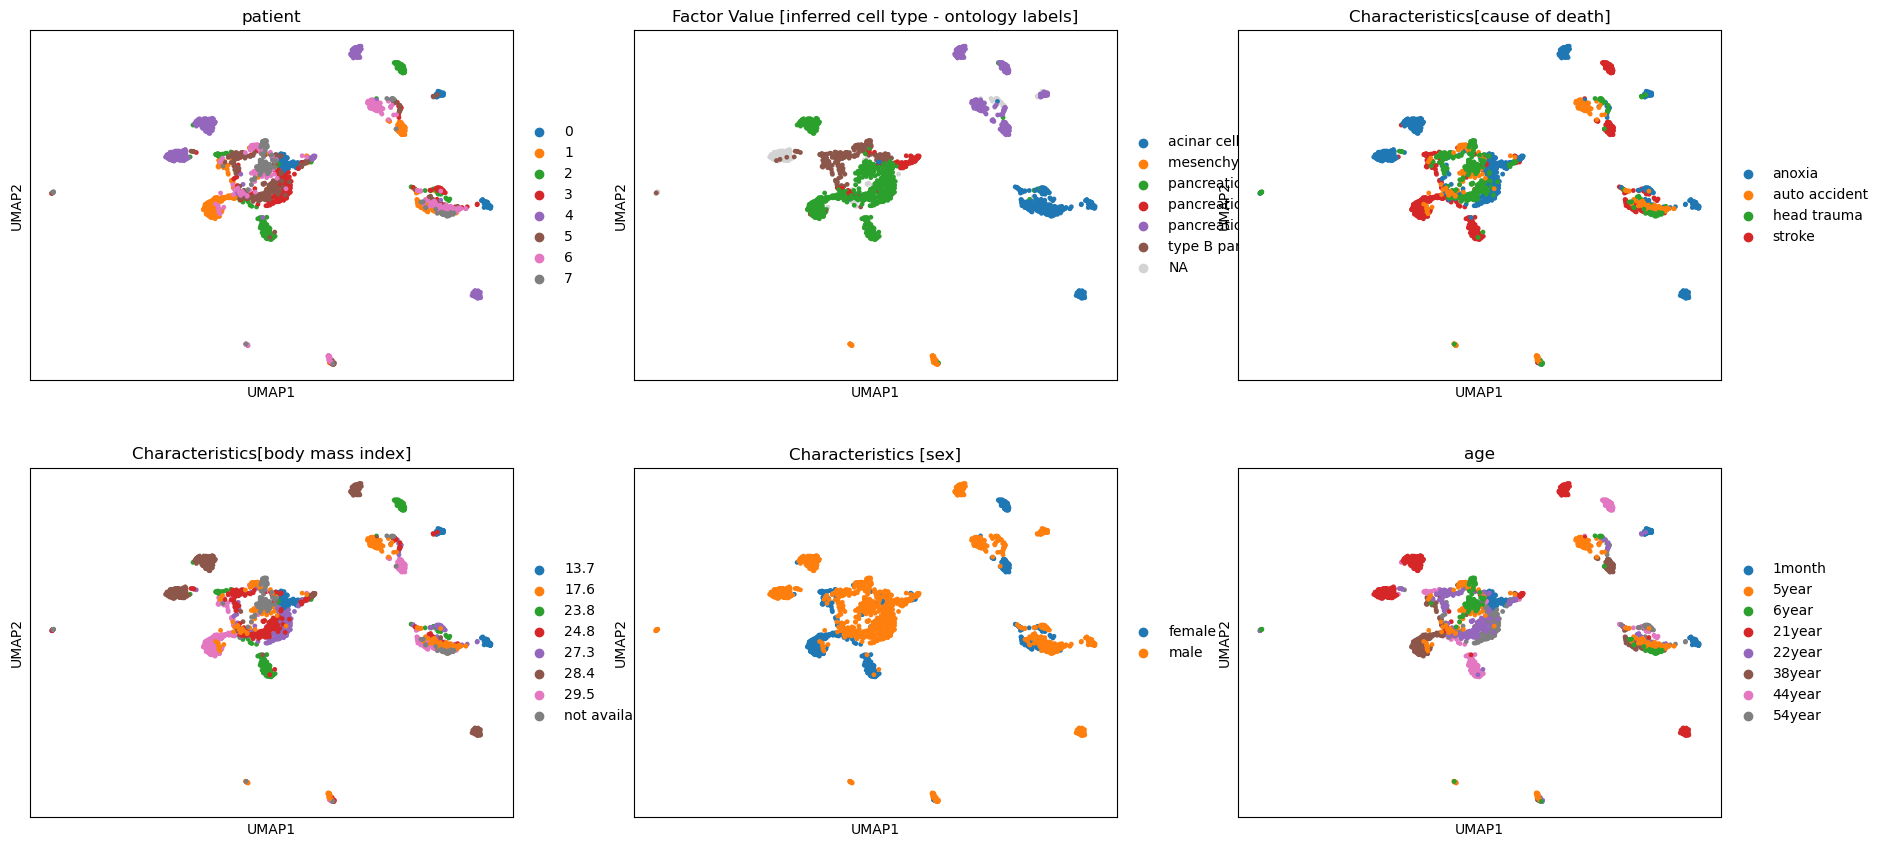

In [39]:
sc.pl.umap(naive, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);

# Downsampling

In [42]:
downsampling = ad.concat(patients.values(), join="outer", label="patient")
# Let's transfer the metadata from a previous file:
downsampling.var = patients["scRSq01"].var[["gene_names", "mitochondrial", "ribosomal"]].copy()
sc.pp.calculate_qc_metrics(downsampling, inplace=True)

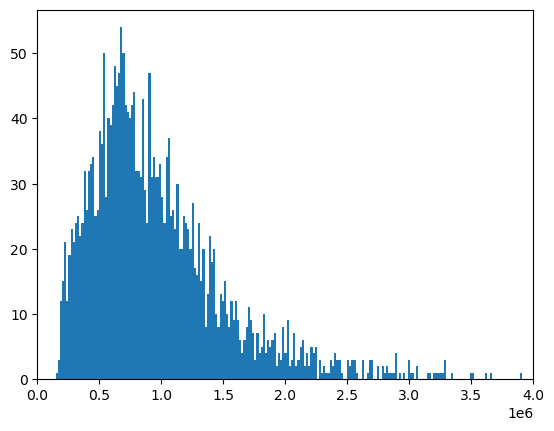

In [47]:
fig, ax = plt.subplots()
ax.hist(downsampling.obs["total_counts"], bins=500)
ax.set_xbound(0, 4e6)

In [48]:
sc.pp.downsample_counts(downsampling, total_counts=1e6)

In [49]:
sc.pp.normalize_per_cell(downsampling, counts_per_cell_after=None)
sc.pp.log1p(downsampling)
sc.pp.highly_variable_genes(downsampling, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(downsampling, n_comps=50, use_highly_variable=True, chunked=True)
sc.pp.neighbors(downsampling, n_neighbors=10, n_pcs=40, metric="cosine")
sc.tl.umap(downsampling, min_dist=0.2)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

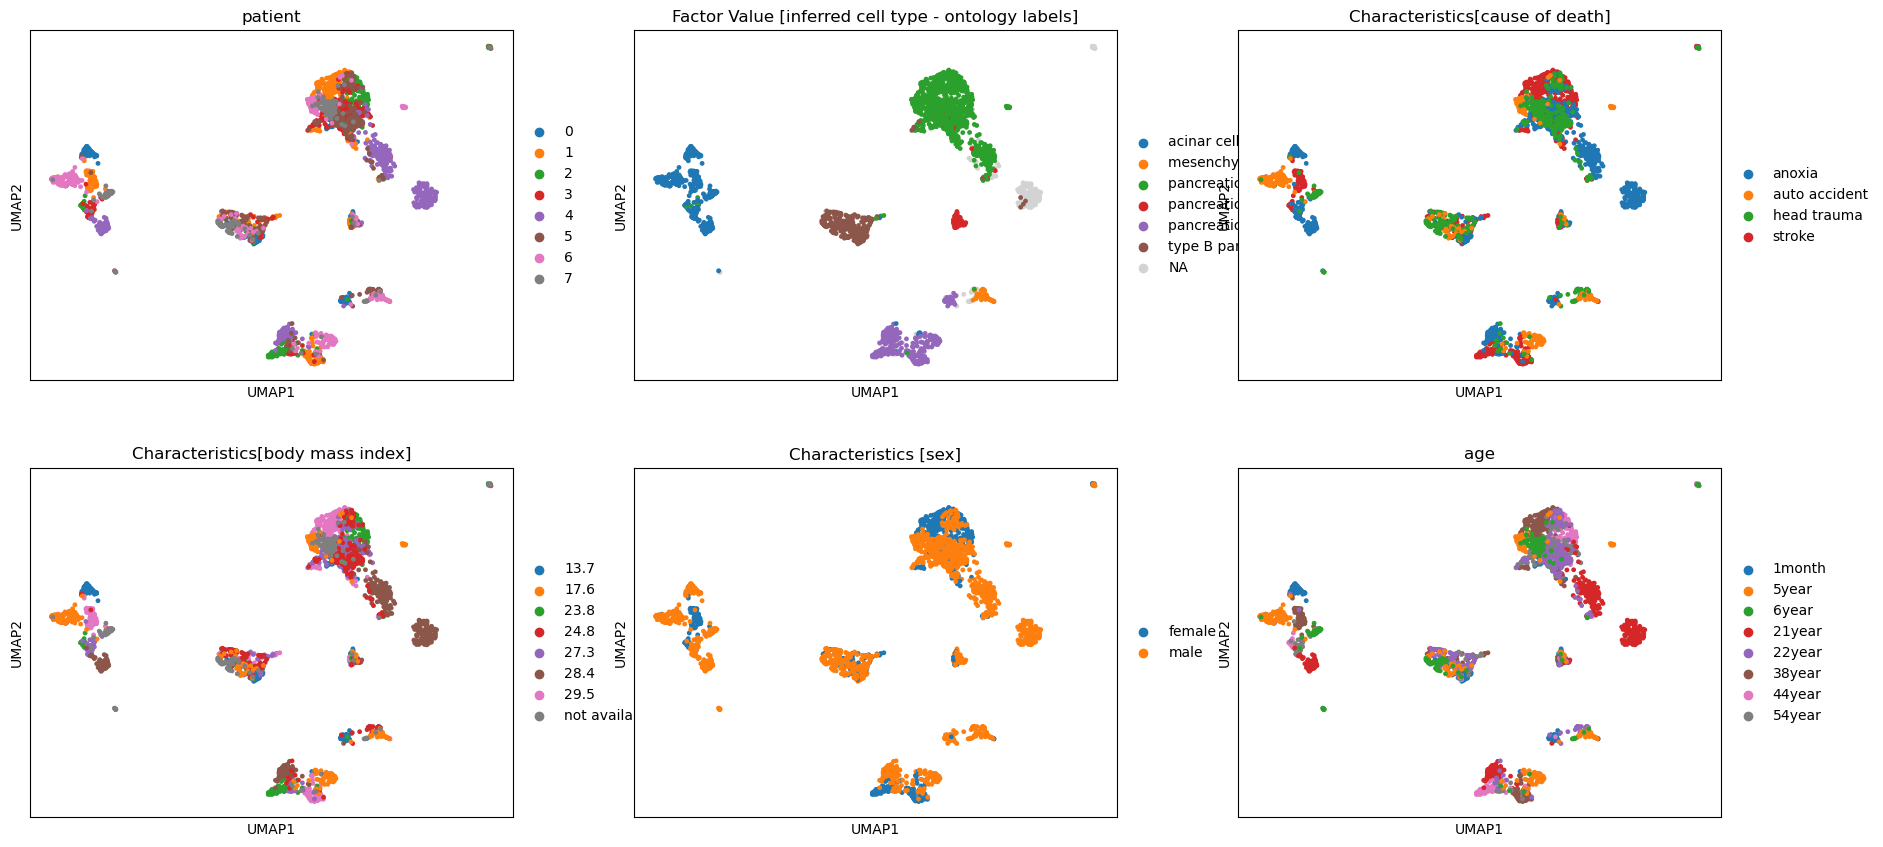

In [50]:
sc.pl.umap(downsampling, color=["patient",
                         "Factor Value [inferred cell type - ontology labels]",
                         "Characteristics[cause of death]",
                         "Characteristics[body mass index]",
                         "Characteristics [sex]",
                         "age"], ncols=3);